In [ ]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "openai/clip-vit-base-patch32"
clip_processor = CLIPProcessor.from_pretrained(model_id)
clip_model = CLIPModel.from_pretrained(model_id)

print("Model Loaded")

Model Loaded


In [ ]:
caption = "A cute puppy playing in the grass"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

image_folder = "/content/drive/MyDrive/Colab Notebooks/Images"  # folder with .jpg, .png, etc.
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('jpg', 'jpeg', 'png'))]
images = [Image.open(p).convert("RGB") for p in image_paths]

print("Loaded images")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded images


In [ ]:
processed_images = clip_processor(
    text=[caption] * len(images),
    images=images,
    return_tensors="pt",
    padding=True
)["pixel_values"]

In [ ]:
text_embedding = model.get_text_features(**clip_processor(text=[caption], return_tensors="pt"))
image_embeddings = model.get_image_features(pixel_values=processed_images)

# Normalize embeddings
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

In [ ]:
similarity_scores = (text_embedding @ image_embeddings.T).squeeze().detach().cpu().numpy()

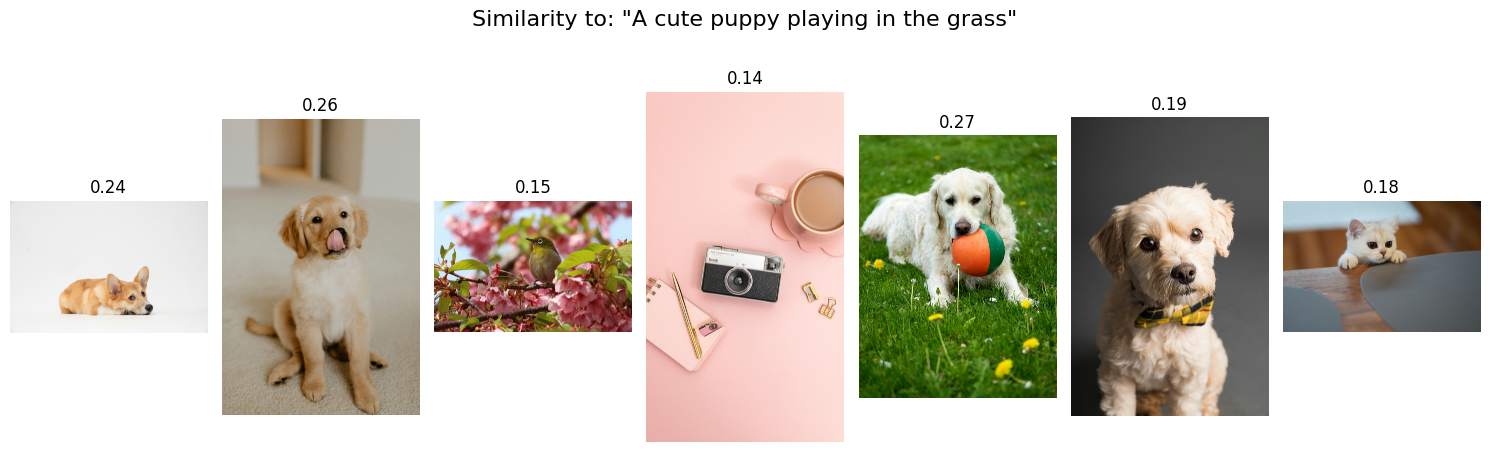

In [ ]:
def plot_images_with_scores(image_paths, scores):
    plt.figure(figsize=(15, 5))
    for i, (path, score) in enumerate(zip(image_paths, scores)):
        img = Image.open(path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(f"{score:.2f}", fontsize=12)
        plt.axis("off")
    plt.suptitle(f"Similarity to: \"{caption}\"", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_images_with_scores(image_paths, similarity_scores)

In [ ]:
To compute the similarity between a given text caption and multiple images I have used OpenAI’s CLIP model (clip-vit-base-patch32).
Steps:
1.Images loaded with PIL.Image and converted to RGB
2.Images and repeated captions passed to CLIPProcessor
3.Text and image features extracted using CLIP model
4.All embeddings normalized using L2 norm
5.Similarity scores calculated using dot product of normalized vectors
Observations:
The highest score (0.27) was given to an image that perfectly aligned with the caption's content — a puppy playing on grass.
Images with partial relevance (just puppy) received moderate scores.
Unrelated or incorrect context images (camera, bird, kitten) scored significantly lower, showing that CLIP captures both semantic meaning and visual context.
Thereefore CLIP can effectively rank images based on how well they match a given text description.